In [1]:
from IPython.display import clear_output
import numpy as np
from framework.io_functions import Reader, Writer
from framework.pre_processing import PreProcessor
from framework.dfts import DFT1D
import matplotlib.pyplot as plt
from framework.ofunction import OFunction
from framework.utilities import real_to_complex, complex_to_real, find_pixel
from framework.priors import TV, L1, Chi2
from framework.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.analytical_functions import Gaussian
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
from pandas.plotting import autocorrelation_plot
import itertools

In [2]:
def normalize(x, a, b):
    xmin = np.min(x)
    xmax = np.max(x)
    x_norm = a + (x-xmin)*(b-a)/(xmax-xmin)
    return x_norm

In [3]:
def gridding(W, P, l2, dl2, epsilon=1e-12):
    l2_grid = np.arange(start=0+epsilon, stop=np.max(l2)+dl2, step=dl2)
    m_grid = len(l2_grid)
    print("The lambda-squared grid will have a size of: {0}".format(m_grid))
    P_grid_real = np.zeros(m_grid)
    P_grid_imag = np.zeros(m_grid)
    W_grid = np.zeros(m_grid)
    
    for i in range(0,len(l2)):
        l2_grid_pos = int(np.floor(l2[i]/dl2))
        if l2_grid_pos >= 0 and l2_grid_pos < m_grid:
            P_grid_real[l2_grid_pos] += W[i] * P[i].real
            P_grid_imag[l2_grid_pos] += W[i] * P[i].imag
            W_grid[l2_grid_pos] += W[i]
    
    valid_idx = np.where(W_grid > 0.0)
    P_grid_real[valid_idx] /= W_grid[valid_idx]
    P_grid_imag[valid_idx] /= W_grid[valid_idx]
    
    P_grid = P_grid_real + 1j * P_grid_imag
    
    K_grid = np.sum(W)
    return W_grid, K_grid, P_grid, l2_grid
    

In [4]:
def remove_channels(nu, remove_frac):
    _chansremoved = []
    while True:
        pos = np.random.randint(0,len(nu))  # get position
        width = np.random.uniform(0,100)  # get chunk size
        low = int(pos - 0.5*width)
        if low<0: low = 0
        high= int(pos + 0.5*width)
        if high>=len(nu): high = len(nu)-1

        _chansremoved.append(list(np.arange(low,high)))
        merged = list(itertools.chain(*_chansremoved))

        chans_removed = np.unique(np.ravel(np.array(merged)))
        frac = float(len(chans_removed))/float(len(nu))
        if frac > remove_frac: break

    # adjust back towards specified fraction
    # using single channel adjustments:
    while True:
        idx = np.random.randint(0,len(chans_removed))
        chans_removed = np.delete(chans_removed, idx)
        frac = float(len(chans_removed))/float(len(nu))
        if frac<=remove_frac: break
    return chans_removed

In [5]:
def make_scenario1(phi_gal, l2, nu0, p0=1.0, phi_0=0.0, alpha=0.0):
    
    nu = c/np.sqrt(l2)
    k = (nu/nu0)**(-1.0*alpha)
    mu_q = p0*k*np.cos(2.*(phi_gal-phi_0)*l2)
    mu_u = p0*k*np.sin(2.*(phi_gal-phi_0)*l2)
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

In [6]:
def make_scenario2(phi_fg, phi_gal, l2, p_fg=1.0, p_gal=0.25):
    
    mu_q = p_fg*np.sin(2*phi_fg*l2)/(2.*phi_fg*l2) + p_gal*np.cos(2.*phi_gal*l2)
    mu_u = p_gal*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

In [7]:
def apply_noise(P, noise=1.0):
    q_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    u_noise = np.random.normal(loc=0.0, scale=noise, size=len(P))
    p_noise = q_noise + 1j * u_noise
    
    P_noisy = P + p_noise
    return P_noisy

In [8]:
class Test:
    def __init__(self, nu_min=None, nu_max=None, nchannels=None, noise_frac=None, remove_frac=None, gridding=True):
        self.nu_min = nu_min
        self.nu_max = nu_max
        self.nchannels = nchannels
        self.noise_frac = noise_frac
        self.remove_frac = 1.0-remove_frac
        self.gridding=gridding
        
        if nu_min is not None:
            self.l2_max = (c/nu_min)**2
        if nu_max is not None:
            self.l2_min = (c/nu_max)**2
            
        if nu_min is not None and nu_max is not None:
            self.nu0 = (nu_max+nu_min)/2
        
        if nu_min is not None and nu_max is not None and nchannels is not None:
            self.nu = np.linspace(nu_min, nu_max, nchannels)
            self.pre_proc = PreProcessor(freqs=self.nu)
        
        if remove_frac is not None and self.remove_frac < 1.0:
            self._remove_channels()
    
    def _remove_channels(self):
        chans_removed = remove_channels(self.nu, self.remove_frac)
        self.nu = self.nu[chans_removed]
        self.pre_proc.freqs = self.nu
    
    def get_faraday_data(self, sigma=None):
        _sigma = np.ones(len(self.nu))
        if sigma is not None:
            _sigma = sigma
        self.W, self.K = self.pre_proc.calculate_W_K(sigma=_sigma)
        self.l2, self.l2_ref, self.phi, self.phi_r = self.pre_proc.calculate_phi(self.W, self.K, times=8, verbose=True)
        self.dft = DFT1D(W=self.W, lambda2=self.l2, lambda2_ref=self.l2_ref, phi=self.phi)
        
    def create_faraday_data(self, phi_fg=None, phi_gal=None, p_gal=1.0, p_fg=0.25, scenario="1"):
        if scenario == "1":
            if phi_gal is not None:
                stokesQ, stokesU = make_scenario1(phi_gal, self.l2, self.nu0, p_gal)
                P = stokesQ + 1j * stokesU
            else:
                print("Couldn't create Faraday Data")
        else:
            if phi_gal is not None and phi_fg is not None:
                stokesQ, stokesU = make_scenario2(phi_fg, phi_gal, self.l2, self.nu0, p_fg, p_gal)
                P = stokesQ + 1j * stokesU
            else:
                print("Couldn't create Faraday Data")
        self.P = P
    
    def _apply_noise(self):
        if self.noise_frac > 0.0:
            print("Applying noise: {0}".format(self.noise_frac))
            self.old_P = self.P
            self.P = apply_noise(self.P, self.noise_frac)
            
    def do_gridding(self):
        self.old_P = self.P
        self.old_l2 = self.l2
        self.old_phi = self.phi
        
        self.W, self.K, self.P, self.l2 = gridding(self.W, self.P, self.l2, self.pre_proc.delta_l2_mean)
        self.old_nu = self.nu
        self.nu = c/np.sqrt(self.l2)
        self.nu = self.nu[::-1]
        self.pre_proc.freqs = self.nu
        self.l2, self.l2_ref, self.phi, self.phi_r = self.pre_proc.calculate_phi(self.W, self.K, times=8, verbose=True)
        self.dft = DFT1D(W=self.W, lambda2=self.l2, lambda2_ref=self.l2_ref, phi=self.phi)
    
    
    def get_rmtf(self, phi_x = 0.0):
        R = self.dft.RMTF(phi_x = phi_x)
        return R
    
    def get_dirty(self):
        F = self.dft.backward(self.P)
        # Get noise from dirty Faraday Spectrum
        idx_noise = np.where(np.abs(self.phi)>8000)
        self.noise_F = np.std(0.5*(F[idx_noise].real + F[idx_noise].imag))
        return F
    
    def run(self, phi_gal=-27.0918, p0=0.0035, lambda_l1=None, lambda_tv=None):
        self.get_faraday_data()
        self.p0 = p0
        self.create_faraday_data(phi_gal=phi_gal, p_gal=self.p0)
        self._apply_noise()
        
        F_dirty_nogrid = self.get_dirty()
        
        if self.gridding:
            self.do_gridding()
            
        self.rmtf = self.get_rmtf()
        self.F_dirty = self.get_dirty()#/self.pre_proc.rmtf_fwhm
        
        noise_fista = self.noise_F#/self.pre_proc.rmtf_fwhm
        print("Noise in dirty Faraday Spectrum {0}".format(noise_fista))
        if lambda_l1 is None:
            lambda_l1 = np.sqrt(2 * len(self.P) + 4 * np.sqrt(len(self.P)))*noise_fista
        
        if lambda_tv is None:
            lambda_tv = 0.0
            
        print(lambda_l1, noise_fista)

        chi2 = Chi2(b=self.P, dft_obj=self.dft, w=self.W)
        l1 = L1(reg=lambda_l1)
        tv = TV(reg=lambda_tv)
        
        F_func = [chi2, l1]
        f_func = [chi2]
        g_func = [l1]

        F_obj = OFunction(F_func)
        f_obj = OFunction(f_func)
        g_obj = OFunction(g_func)

        F_real = complex_to_real(self.F_dirty)
        
        opt = FISTA(F_obj=F_obj, i_guess=np.zeros_like(F_real), verbose=True, fx=chi2, gx=g_obj, noise=noise_fista)
        #opt = GradientBasedMethod(F_obj=F_obj, i_guess=F_real, maxiter=100, verbose=True)
        obj, X = opt.run()
        X = real_to_complex(X)
        
        F_recon = X * self.K/len(self.phi)
        self.F_recon_test = F_recon
        
        self.P_recon = self.dft.forward_normalized(X)
        
        # Residuals
        self.P_residual = self.P-self.P_recon
        self.F_residual = self.dft.backward(self.P_residual)
        
        # Make clean beam Gaussian
        self.clean_rmtf = Gaussian(x=self.phi, fwhm=self.pre_proc.rmtf_fwhm)
        clean_beam_kernel = self.clean_rmtf.run(normalized=True)
        
        #print("Max kernel: {0}".format(np.max(clean_beam_kernel)))
        #print("Min kernel: {0}".format(np.min(clean_beam_kernel)))
        
        # Convolve model with clean beam and sum residuals up
        F_conv = sci_signal.convolve(F_recon, clean_beam_kernel, mode='full', method='auto')
        F_restored = F_conv[len(self.phi)//2:(len(self.phi)//2)+len(self.phi)] + self.F_residual
        P_restored = self.dft.forward_normalized(F_restored * len(self.phi) / self.K)
           
        # Do the plots
        fig, ax = plt.subplots(1, 4, figsize=(12,8), tight_layout=True, sharey=True, squeeze=True)
        
        ax[0].plot(self.old_l2, self.old_P.real, 'k.', label=r"Stokes $Q$")
        ax[0].plot(self.old_l2, self.old_P.imag, 'c.', label=r"Stokes $U$")
        ax[0].plot(self.old_l2, np.abs(self.old_P), 'g.', label=r"$|P|$")
        #ax[0].set_box_aspect(1)
        
        ax[1].plot(self.l2, self.P.real, 'k.', label=r"Stokes $Q$")
        ax[1].plot(self.l2, self.P.imag, 'c.', label=r"Stokes $U$")
        ax[1].plot(self.l2, np.abs(self.P), 'g.', label=r"$|P|$")
        #ax[1].set_box_aspect(1)
        
        ax[2].plot(self.l2, self.P_recon.real, 'k.', label=r"Stokes $Q$")
        ax[2].plot(self.l2, self.P_recon.imag, 'c.', label=r"Stokes $U$")
        ax[2].plot(self.l2, np.abs(self.P_recon), 'g.', label=r"$|P|$")
        #ax[2].set_box_aspect(1)
        
        ax[3].plot(self.l2, self.P_residual.real, 'k.', label=r"Stokes $Q$")
        ax[3].plot(self.l2, self.P_residual.imag, 'c.', label=r"Stokes $U$")
        ax[3].plot(self.l2, np.abs(self.P_residual), 'g.', label=r"$|P|$")
        #ax[3].set_box_aspect(1)
        
        #ax[4].plot(self.l2, P_restored.real, 'k.', label=r"Stokes $Q$")
        #ax[4].plot(self.l2, P_restored.imag, 'c.', label=r"Stokes $U$")
        #ax[4].plot(self.l2, np.abs(P_restored), 'g.', label=r"$|P|$")
        #ax[4].set_box_aspect(1)
        
        fig2, ax2 = plt.subplots(1, 5, figsize=(12,8), tight_layout=True, sharey=True, squeeze=True)
        
        ax2[0].plot(self.old_phi, F_dirty_nogrid.real, 'c--', label=r"Real part")
        ax2[0].plot(self.old_phi, F_dirty_nogrid.imag, 'c:', label=r"Imaginary part")
        ax2[0].plot(self.old_phi, np.abs(F_dirty_nogrid), 'k-', label=r"Amplitude")
        ax2[0].set_xlim([-500,500])
        #ax2[0].set_box_aspect(1)
        
        ax2[1].plot(self.phi, self.F_dirty.real, 'c--', label=r"Real part")
        ax2[1].plot(self.phi, self.F_dirty.imag, 'c:', label=r"Imaginary part")
        ax2[1].plot(self.phi, np.abs(self.F_dirty), 'k-', label=r"Amplitude")
        ax2[1].set_xlim([-500,500])
        #ax2[1].set_box_aspect(1)
        
        ax2[2].plot(self.phi, F_recon.real, 'c--', label=r"Real part")
        ax2[2].plot(self.phi, F_recon.imag, 'c:', label=r"Imaginary part")
        ax2[2].plot(self.phi, np.abs(F_recon), 'k-', label=r"Amplitude")
        ax2[2].set_xlim([-500,500])
        #ax2[2].set_box_aspect(1)
        
        ax2[3].plot(self.phi, self.F_residual .real, 'c--', label=r"Real part")
        ax2[3].plot(self.phi, self.F_residual .imag, 'c:', label=r"Imaginary part")
        ax2[3].plot(self.phi, np.abs(self.F_residual), 'k-', label=r"Amplitude")
        ax2[3].set_xlim([-500,500])
        #ax2[3].set_box_aspect(1)
        
        ax2[4].plot(self.phi, F_restored.real, 'c--', label=r"Real part")
        ax2[4].plot(self.phi, F_restored.imag, 'c:', label=r"Imaginary part")
        ax2[4].plot(self.phi, np.abs(F_restored), 'k-', label=r"Amplitude")
        ax2[4].set_xlim([-500,500])
        #ax2[4].set_box_aspect(1)
        
        fig.tight_layout()
        fig2.tight_layout()
        
        self.lambda2_fig = fig
        self.phi_fig = fig2
        
        # Return important statistics
        # - SNR
        # - Root mean squared
        res_noise = 0.5*(np.std(self.F_residual.real) + np.std(self.F_residual.imag))
        meaningful_signal = np.where(np.abs(self.phi) < self.pre_proc.max_faraday_depth)
        signal = np.mean(np.abs(F_recon[meaningful_signal]))
        peak_signal = np.max(np.abs(F_recon))
        
        self.peak = peak_signal
        self.noise = res_noise
        self.snr = signal / res_noise
        self.psnr = peak_signal / res_noise
        self.rmse = np.abs(np.abs(self.p0) - peak_signal)/self.p0
        
        print("Absolute model peak: {0}".format(self.peak))
        print("Original peak value: {0}".format(np.abs(self.p0)))
        print("Signal-to-noise ratio: {0}".format(self.snr))
        print("Peak Signal-to-noise ratio: {0}".format(self.psnr))
        print("Root mean squared error: {0}".format(self.rmse))

In [9]:
np.random.seed(666)

In [10]:
p0 = 0.004
nsigma = [3.0, 4.0, 5.0, 6.0, 8.0, 10.0] # 3.5
remove_frac = [0.0, 0.05, 0.1, 0.25, 0.5, 0.53, 0.7] # 0.53

In [11]:
test_objs = []

for nsig in nsigma:
    for remv_frac in remove_frac:
        test_objs.append(Test(nu_min=1.008e9, nu_max=2.031e9, nchannels=1000, noise_frac=p0/nsig, remove_frac=remv_frac, gridding=True))

In [12]:
nid = len(nsigma)*len(remove_frac)
for _id in range(0, nid):
    test_objs[_id].run(p0=p0)

Minimum Lambda-squared: 0.022 m^2
Maximum Lambda-squared: 0.088 m^2
delta Lambda-squared min: 2.199e-05 m^2
delta Lambda-squared max: 0.000 m^2
delta Lambda-squared mean: 6.673e-05 m^2
FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Applying noise: 0.0013333333333333333
The lambda-squared grid will have a size of: 1327
Minimum Lambda-squared: 0.000 m^2
Maximum Lambda-squared: 0.088 m^2
delta Lambda-squared min: 6.673e-05 m^2
delta Lambda-squared max: 0.000 m^2
delta Lambda-squared mean: 6.673e-05 m^2
FWHM of the main peak of the RMTF: 39.148 rad/m^2
Maximum recovered width structure: 3141592653589.793 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Noise in dirty Faraday Spectrum 4.742440796690062e-05
0.002509334749718205 4.7424408e-05
Iterations set to 52
Iteration:  0  objective function value: 0.00915
Iteration:  50  obj

The lambda-squared grid will have a size of: 1327
Minimum Lambda-squared: 0.000 m^2
Maximum Lambda-squared: 0.088 m^2
delta Lambda-squared min: 6.673e-05 m^2
delta Lambda-squared max: 0.000 m^2
delta Lambda-squared mean: 6.673e-05 m^2
FWHM of the main peak of the RMTF: 39.148 rad/m^2
Maximum recovered width structure: 3141592653589.793 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Noise in dirty Faraday Spectrum 4.1122159018414095e-05
0.00217586822971758 4.112216e-05
Iterations set to 52
Iteration:  0  objective function value: 0.00753
Iteration:  50  objective function value: 0.00108
Absolute model peak: 0.0016093613812699914
Original peak value: 0.004
Signal-to-noise ratio: 0.0291795700450833
Peak Signal-to-noise ratio: 42.886320751424506
Root mean squared error: 0.5976596546825022
Minimum Lambda-squared: 0.022 m^2
Maximum Lambda-squared: 0.088 m^2
delta Lambda-squared min: 2.202e-05 m^2
delta Lambda-squared max: 0.004 m^2
delta Lambda-squared me

limit_output extension: Maximum message size of 10000 exceeded with 10405 characters

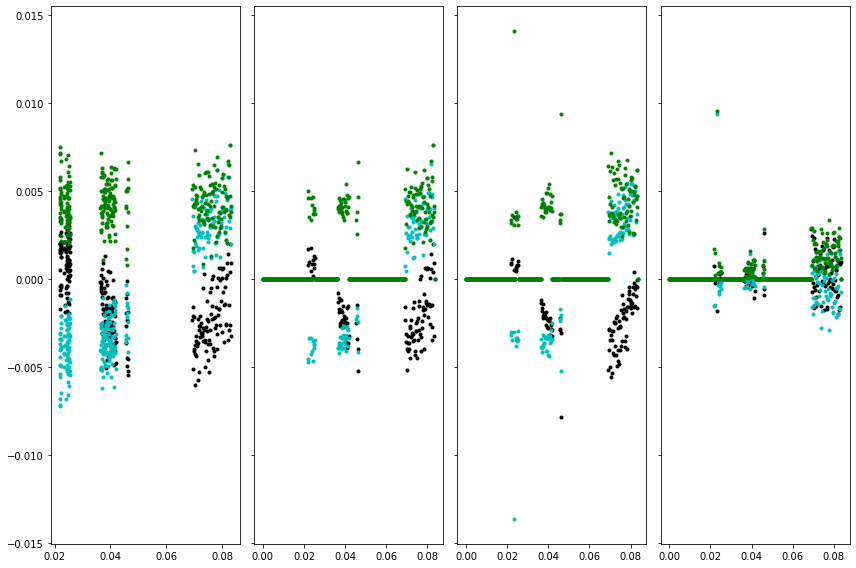

In [13]:
test_objs[6].lambda2_fig

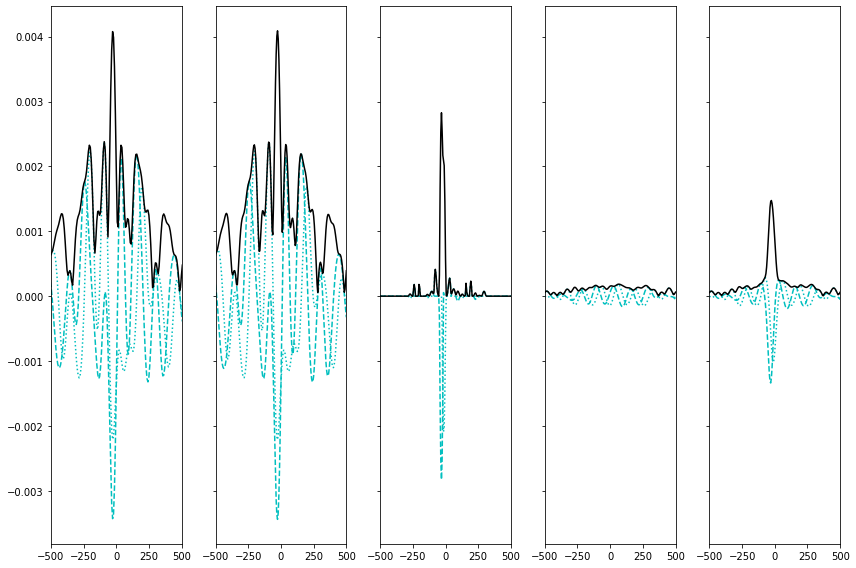

In [14]:
test_objs[6].phi_fig

In [15]:
#nsigma = [2.0, 3.5, 5.0, 10.0, 50.0, 100.0] # 3.5
#remove_frac = [0.0, 0.05, 0.1, 0.25, 0.5, 0.53, 0.7] # 0.53
str_frac = str(remove_frac).replace("[", "").replace("]","").replace(",", "")
print("N\R", end="|")
print(" "+str_frac, end=" \n")
print("="*8*len(remove_frac))
for i in range(0, len(nsigma)):
    for j in range(0, len(remove_frac)):
        _id = len(remove_frac)*i + j
        if j==0:
            print(nsigma[i], end=" ")
            print("|", end=" ")
        print("{0:.3f}".format(test_objs[_id].psnr), end=" ")
        if j==len(remove_frac)-1:
            print("|", end=" ")
    print("\n")
print("="*8*len(remove_frac))

N\R| 0.0 0.05 0.1 0.25 0.5 0.53 0.7 
3.0 | 36.808 38.843 42.760 49.963 40.018 31.854 35.440 | 

4.0 | 42.886 45.150 48.527 54.232 29.973 37.341 21.399 | 

5.0 | 49.509 51.199 51.169 47.323 40.599 47.057 29.403 | 

6.0 | 50.747 50.505 50.588 44.401 34.507 36.646 48.335 | 

8.0 | 57.008 59.520 63.775 48.126 37.394 46.754 26.210 | 

10.0 | 58.659 61.589 64.723 61.329 55.585 50.173 28.317 | 



In [16]:
#nsigma = [2.0, 3.5, 5.0, 10.0, 50.0, 100.0] # 3.5
#remove_frac = [0.0, 0.05, 0.1, 0.25, 0.5, 0.53, 0.7] # 0.53
str_frac = str(remove_frac).replace("[", "").replace("]","").replace(",", "")
print("N\R", end="|")
print(" "+str_frac, end=" \n")
print("="*8*len(remove_frac))
for i in range(0, len(nsigma)):
    for j in range(0, len(remove_frac)):
        _id = len(remove_frac)*i + j
        if j==0:
            print(nsigma[i], end=" ")
            print("|", end=" ")
        print("{0:.3f}".format(test_objs[_id].rmse), end=" ")
        if j==len(remove_frac)-1:
            print("|", end=" ")
    print("\n")
print("="*8*len(remove_frac))

N\R| 0.0 0.05 0.1 0.25 0.5 0.53 0.7 
3.0 | 0.570 0.570 0.578 0.533 0.506 0.515 0.293 | 

4.0 | 0.598 0.588 0.575 0.532 0.634 0.481 0.575 | 

5.0 | 0.583 0.580 0.583 0.587 0.554 0.431 0.577 | 

6.0 | 0.598 0.603 0.592 0.611 0.542 0.526 0.468 | 

8.0 | 0.601 0.595 0.573 0.540 0.531 0.533 0.620 | 

10.0 | 0.601 0.592 0.576 0.565 0.535 0.448 0.524 | 



In [17]:
_id = 6
old_lambda2 = test_objs[_id].old_l2
lambda2 = test_objs[_id].l2
phi = test_objs[_id].phi
gauss_rmtf = Gaussian(x=phi, fwhm=test_objs[_id].pre_proc.rmtf_fwhm)
gauss_rmtf_array = gauss_rmtf.run(normalized=True)
gauss_rmtf_nonor = gauss_rmtf.run(normalized=False)
F_recon = test_objs[_id].F_recon_test#/gauss_rmtf.fwhm
residual = test_objs[_id].F_residual
P_recon = test_objs[_id].P_recon
P_residual = test_objs[_id].P_residual
F_conv = sci_signal.convolve(F_recon, gauss_rmtf_array, mode='full', method='auto') 
F_restored_conv = F_conv[len(phi)//2:(len(phi)//2)+len(phi)] + residual

F_truth = np.zeros_like(F_recon, dtype=np.complex128)
idx = np.argmax(np.abs(F_recon))#np.where(phi==-27.0918)
F_truth[idx] = 0.004
F_truth_c = sci_signal.convolve(F_truth, gauss_rmtf_array, mode='full', method='auto')
F_truth_conv = F_truth_c[len(phi)//2:(len(phi)//2)+len(phi)]

NameError: name 'F_restored' is not defined

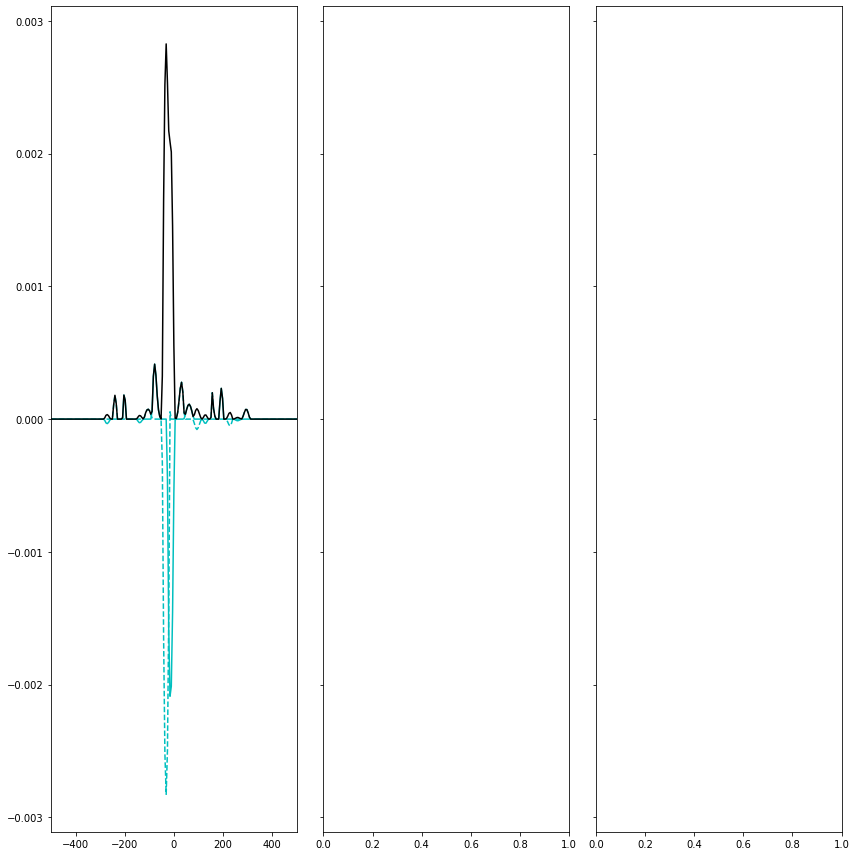

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12,12), tight_layout=True, sharey=True, squeeze=True)

#ax[1].plot(test_objs[_id].phi, gauss_rmtf)
#ax[1].set_xlim([-200,200])

ax[0].plot(phi, F_recon.real, 'c--', label=r"Real part")
ax[0].plot(phi, F_recon.imag, 'c-', label=r"Imaginary part")
ax[0].plot(phi, np.abs(F_recon), 'k-', label=r"Amplitude")
ax[0].set_xlim([-500,500])

ax[1].plot(phi, F_restored.real, 'c--', label=r"Real part")
ax[1].plot(phi, F_restored.imag, 'c-', label=r"Imaginary part")
ax[1].plot(phi, np.abs(F_restored), 'k-', label=r"Amplitude")
ax[1].set_xlim([-500,500])

ax[2].plot(phi, F_truth_conv.real, 'c--', label=r"Real part")
ax[2].plot(phi, F_truth_conv.imag, 'c-', label=r"Imaginary part")
ax[2].plot(phi, np.abs(F_truth_conv), 'k-', label=r"Amplitude")
ax[2].set_xlim([-500,500])

In [ ]:
def autocorr(x):
    result = sci_signal.correlate(x/np.std(x), x/np.std(x), mode='full', method='auto')
    result /= len(x)
    return result[result.size//2:]

In [ ]:
# Do the same by hand
autocorr_real = autocorr(P_residual.real)
autocorr_imag = autocorr(P_residual.imag)
autocorr_res = autocorr_real + 1j * autocorr_imag

lags = sci_signal.correlation_lags(len(lambda2), len(lambda2), mode="full")
lags_pos = np.where(lags >= 0)
lags = lags[lags_pos]

In [ ]:
from scipy import special

vcrit = np.sqrt(2)*special.erfinv(0.95)
print(vcrit)
bound= vcrit/np.sqrt(len(lambda2))
print(bound)

fig_acorr, ax2_acorr = plt.subplots(1, 2, figsize=(5,5), tight_layout=True, sharey=True, squeeze=True)

ax2_acorr[0].plot(lags, autocorr_res.real, 'c-', label=r"Real part")
ax2_acorr[1].plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
ax2_acorr[0].axhline(-bound)
ax2_acorr[0].axhline(bound)
ax2_acorr[1].axhline(-bound)
ax2_acorr[1].axhline(bound)
ax2_acorr[0].grid()
ax2_acorr[1].grid()
#plt.plot(lags, np.abs(autocorr_res), 'k-', label=r"Amplitude")
ax2_acorr[0].set_xlim([-20,len(lags)-1])
ax2_acorr[1].set_xlim([-20,len(lags)-1])

In [ ]:
elem_real = ((autocorr_res.real > -bound) & (autocorr_res.real < bound)).sum()
100.0*elem_real/len(lags)

In [ ]:
elem_imag = ((autocorr_res.imag > -bound) & (autocorr_res.imag < bound)).sum()
100.0*elem_imag/len(lags)

In [ ]:
from scipy.interpolate import interp1d
f_func = interp1d(lambda2, P_residual, kind='cubic')#, fill_value="extrapolate")
f_mod_func = interp1d(lambda2, P_recon, kind='cubic')#, fill_value="extrapolate")

In [ ]:
P_interp = f_func(old_lambda2)
P_mod = f_mod_func(old_lambda2)

In [ ]:
plt.plot(old_lambda2, P_interp.real, 'k.', label=r"Stokes $Q$")
plt.plot(old_lambda2, P_interp.imag, 'c.', label=r"Stokes $U$")
plt.plot(old_lambda2, np.abs(P_interp), 'g.', label=r"$|P|$")

In [ ]:
plt.plot(old_lambda2, P_mod.real, 'k.', label=r"Stokes $Q$")
plt.plot(old_lambda2, P_mod.imag, 'c.', label=r"Stokes $U$")
plt.plot(old_lambda2, np.abs(P_mod), 'g.', label=r"$|P|$")

In [ ]:
autocorr_real = autocorr(P_interp.real)
autocorr_imag = autocorr(P_interp.imag)
autocorr_res = autocorr_real + 1j * autocorr_imag

lags = sci_signal.correlation_lags(len(old_lambda2), len(old_lambda2), mode="full")
lags_pos = np.where(lags >= 0)
lags = lags[lags_pos]

In [ ]:
from scipy import special

vcrit = np.sqrt(2)*special.erfinv(0.95)
print(vcrit)
bound= vcrit/np.sqrt(len(old_lambda2));
print(bound)

fig_acorr, ax2_acorr = plt.subplots(1, 2, figsize=(5,5), tight_layout=True, sharey=True, squeeze=True)

ax2_acorr[0].plot(lags, autocorr_res.real, 'c-', label=r"Real part")
ax2_acorr[1].plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
ax2_acorr[0].axhline(-bound)
ax2_acorr[0].axhline(bound)
ax2_acorr[1].axhline(-bound)
ax2_acorr[1].axhline(bound)
ax2_acorr[0].grid()
ax2_acorr[1].grid()
#plt.plot(lags, np.abs(autocorr_res), 'k-', label=r"Amplitude")
ax2_acorr[0].set_xlim([-20,len(lags)])
ax2_acorr[1].set_xlim([-20,len(lags)])

In [ ]:
elem_real = ((autocorr_res.real > -bound) & (autocorr_res.real < bound)).sum()
100.0*elem_real/len(lags)

In [ ]:
elem_imag = ((autocorr_res.imag > -bound) & (autocorr_res.imag < bound)).sum()
100.0*elem_imag/len(lags)

In [ ]:
pre_proc = PreProcessor(freqs=test_objs[_id].old_nu)

In [ ]:
W, K = pre_proc.calculate_W_K(sigma=np.ones_like(old_lambda2))
l2, l2_ref, phi, phi_r = pre_proc.calculate_phi(W, K, times=8, verbose=True)
dft = DFT1D(W=W, lambda2=l2, lambda2_ref=l2_ref, phi=phi)

In [ ]:
F_res = dft.backward(P_mod)

In [ ]:
plt.plot(phi, F_res.real, 'c--', label=r"Real part")
plt.plot(phi, F_res.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_res), 'k-', label=r"Amplitude")
plt.xlim([-700,700])